In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential,Model, Input
from keras.layers.convolutional import Conv2D,Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, SeparableConv2D , DepthwiseConv2D, concatenate,Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from keras import backend as k

from keras.datasets import cifar10

Using TensorFlow backend.


In [0]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
print("Number of images in the Train dataset : {}".format(num_train))
print("Number of classes : {}".format(num_classes))
print("Shape of the train dataset : {}".format(train_features.shape))
print("Shape of the test dataset : {}".format(test_features.shape))

Number of images in the Train dataset : 50000
Number of classes : 10
Shape of the train dataset : (50000, 32, 32, 3)
Shape of the test dataset : (10000, 32, 32, 3)


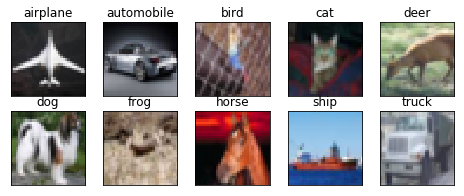

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)
  
def space_to_depth_x4(x):
    return tf.space_to_depth(x, block_size=4)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

###Image Normalization

In [0]:
from keras.preprocessing.image import ImageDataGenerator
# standardizing the image cifar10 dataset

# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()

# report pixel means and standard deviations of train and test datasets
print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator = datagen.flow(trainX, trainy, batch_size=64)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(64, 32, 32, 3) 0.02664386 1.0631433
(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
# Reshape the input to have the dimension for channel
iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy

In [0]:
# One - hot encoding
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Rewriting the CIFAR10 model again for 100 epochs using the ENAS architecture:
  
References:

1. https://arxiv.org/pdf/1802.03268.pdf
2. https://github.com/amitdoda1983/EVA-Session-7/blob/master/Session_7_M6_Amit_Doda.ipynb
3.https://github.com/pratikiiitb2013/EVA/blob/master/Session7/Assignment_7B.ipynb
4. https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

Depthwise Separable Convolution : <br>
"The depthwise separable convolution is so named because it deals not just with the spatial dimensions, but with the depth dimension — the number of channels — as well. An input image may have 3 channels: RGB. After a few convolutions, an image may have multiple channels. You can image each channel as a particular interpretation of that image; in for example, the “red” channel interprets the “redness” of each pixel, the “blue” channel interprets the “blueness” of each pixel, and the “green” channel interprets the “greenness” of each pixel. An image with 64 channels has 64 different interpretations of that image.[4]""


In [0]:
# Define the model



m_input = Input(shape=(32,32,3))

# Layer 1. Depthwise 5x5 separable convolution
x1 = SeparableConv2D(32, (5, 5),border_mode='same')(m_input)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Dropout(0.1)(x1)

# Layer 2. Normal 5x5 convolution
x2 = Conv2D(16, (5,5), border_mode='same')(x1)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = Dropout(0.1)(x2)

# Layer 3. Normal 5x5 convolution
x3 = Conv2D(16, (5,5), border_mode='same')(x2)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
x3 = Dropout(0.1)(x3)

# Layer 4. Depthwise 5x5 separable convolution
x4 = SeparableConv2D(16, (5, 5),border_mode='same')(concatenate([x3,x1]))
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = Dropout(0.1)(x4)

# Layer 5. Max pooling 
x5 = MaxPooling2D(pool_size=(2, 2))(concatenate([x4,x1]))

# Bottleneck 1x1 
'''this will reduce parameters
This dimensionality reduction technique prevents 
the number of feature maps to be processed '''
x5 = Conv2D(8, (1, 1), activation='relu')(x5)

# Layer 6. Depthwise 3x3 separable convolution
x6 = SeparableConv2D(16, (3, 3),border_mode='same')(x5)
x6 = BatchNormalization()(x6)
x6 = Activation('relu')(x6)
x6 = Dropout(0.1)(x6)

# Layer 7. Normal 5x5 convolution
x7 = Conv2D(16, (5,5), border_mode='same')(concatenate([x6, Lambda(space_to_depth_x2)(x1), Lambda(space_to_depth_x2)(x4)]))
x7 = BatchNormalization()(x7)
x7 = Activation('relu')(x7)
x7 = Dropout(0.1)(x7)

# Layer 8. Depthwise 3x3 separable convolution
x8 = SeparableConv2D(16, (3, 3),border_mode='same')(concatenate([x7, Lambda(space_to_depth_x2)(x3),Lambda(space_to_depth_x2)(x4), x6]))
x8 = BatchNormalization()(x8)
x8 = Activation('relu')(x8)
x8 = Dropout(0.1)(x8)

# Layer 9. Depthwise 5x5 separable convolution
x9 = SeparableConv2D(32, (5, 5),border_mode='same')(concatenate([x8, Lambda(space_to_depth_x2)(x1), Lambda(space_to_depth_x2)(x3), Lambda(space_to_depth_x2)(x4), x6, x7]))
x9 = BatchNormalization()(x9)
x9 = Activation('relu')(x9)
x9 = Dropout(0.1)(x9)

# Layer 10. Max pooling 
x10 = MaxPooling2D(pool_size=(2, 2))(concatenate([x9, Lambda(space_to_depth_x2)(x1), Lambda(space_to_depth_x2)(x4), x6, x8]))

# Bottleneck 1x1 
'''this will reduce parameters
This dimensionality reduction technique prevents 
the number of feature maps to be processed '''
x10 = Conv2D(32, (1, 1), activation='relu')(x10)
x10 = Dropout(0.1)(x10)

# Layer 11. Normal 5x5 convolution
x11 = Conv2D(32, (5,5), border_mode='same')(concatenate([x10, Lambda(space_to_depth_x2)(x7)]))
x11 = BatchNormalization()(x11)
x11 = Activation('relu')(x11)
x11 = Dropout(0.1)(x11)

# Layer 12. Depthwise 5x5 separable convolution
x12 = SeparableConv2D(32, (5, 5),border_mode='same')(concatenate([x11,Lambda(space_to_depth_x4)(x1),Lambda(space_to_depth_x4)(x2),Lambda(space_to_depth_x4)(x4),Lambda(space_to_depth_x2)(x8)]))
x12 = BatchNormalization()(x12)
x12 = Activation('relu')(x12)
x12 = Dropout(0.1)(x12)

# Layer 13. Normal 3x3 convolution
x13 = Conv2D(32, (3,3), border_mode='same')(concatenate([x12,Lambda(space_to_depth_x4)(x2),Lambda(space_to_depth_x4)(x3),MaxPooling2D((2,2))(x6),x11]))
x13 = BatchNormalization()(x13)
x13 = Activation('relu')(x13)
x13 = Dropout(0.1)(x13)

# Layer 14. Depthwise 5x5 separable convolution
x14 = SeparableConv2D(64, (5, 5),border_mode='same')(concatenate([x13,Lambda(space_to_depth_x4)(x1),Lambda(space_to_depth_x4)(x3),Lambda(space_to_depth_x4)(x4),Lambda(space_to_depth_x2)(x6),Lambda(space_to_depth_x2)(x8),x12]))
x14 = BatchNormalization()(x14)
x14 = Activation('relu')(x14)
x14 = Dropout(0.1)(x14)

x15 = concatenate([x14,Lambda(space_to_depth_x4)(x4),Lambda(space_to_depth_x2)(x8),x12])

# Bottleneck 1x1
'''this will reduce parameters
idea is that after every concatenation; 
a 1 × 1 convolution 
This dimensionality reduction technique prevents 
the number of feature maps to be processed '''
x16 = Conv2D(10, (1, 1), activation='relu')(x15)
x16 = AveragePooling2D(8,8)(x16)
x16=  Flatten()(x16)
x16 = Activation(activation='softmax')(x16)


model = Model(m_input, x16, name='cnn')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(16, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(16, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Conv2D` call to the 

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_8 (SeparableCo (None, 32, 32, 32)   203         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 32, 32, 32)   128         separable_conv2d_8[0][0]         
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 32, 32, 32)   0           batch_normalization_13[0][0]     
__________________________________________________________________________________________________
dropout_15

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 73s 188ms/step - loss: 1.4611 - acc: 0.4685 - val_loss: 1.6693 - val_acc: 0.4372
Epoch 2/100
390/390 [==============================] - 66s 168ms/step - loss: 1.0556 - acc: 0.6211 - val_loss: 1.0079 - val_acc: 0.6432
Epoch 3/100
390/390 [==============================] - 66s 169ms/step - loss: 0.9125 - acc: 0.6745 - val_loss: 1.0984 - val_acc: 0.6181
Epoch 4/100
390/390 [==============================] - 66s 168ms/step - loss: 0.8146 - acc: 0.7092 - val_loss: 0.8849 - val_acc: 0.6930
Epoch 5/100
390/390 [==============================] - 65s 167ms/step - loss: 0.7503 - acc: 0.7361 - val_loss: 0.9542 - val_acc: 0.6569
Epoch 6/100
390/390 [==============================] - 65s 167ms/step - loss: 0.6981 - acc: 0.7550 - val_loss: 0.8073 - val_acc: 0.7112
Epoch 7/100
390/390 [==============================] - 65s 167ms/step - loss: 0.6550 - acc: 0.7714 - val_loss: 0.9496 - val_acc: 0.6665
Epoch 8/100
390/390 [==============================] - 65s 1

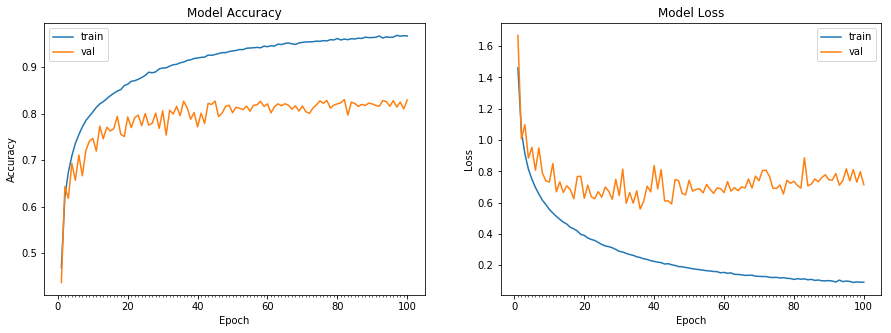

Accuracy on test data is: 82.94


In [19]:
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam

BATCH_SIZE = 64
EPOCHS = 100

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, zoom_range=0.0, horizontal_flip=True)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (X_test, Y_test), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model))

In [0]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [23]:
print(score)

[0.7150343344151974, 0.8294]


#Observation
Accuracy achieved is 82.94%  